# Applied Data Science Capstone: Segementing and Clustering Neighborhoods in SF

## 1. Introduction
You and your partner have been together for over a year now. They decide on the location everytime you both go out. This past week, your partner mentioned how they would like you to plan a day in the city. Your mind is blank. You don't much about the city, yet any activities to do there. Luckily for you, you have the demonstrated ability to solve this problem by applying the skills you've learned working to achieve IBM's Data Science Profession Certificate. Yes, you is me.

### 1.1. Business Problem
No business problem, just a personal problem :)

Just kidding. There is one underlying theme I would like to get across and that is the importance of location in a business. The location of a business has been and always will be important. A business's location not only attracts their customers but also plays an essential role in attracting and retaining the best employees, many of whom prioritize location in order to optimize work-life balance. Real estate cost is the second largest expense of a business after labor costs, so naturally finding a location with optimal real estate cost is efficient for a business. Lasty, factors in city ordinance and accessibility will be crucial for a business location. What kind of laws and regulations will your business be operating under? Will the business have access to new markets, customers and resources?


## 2. Data
In order to make the best possible decision, we will need to acquire some data. 
- [San Francisco Neighborhood Data](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)
- [San Francisco Crime Data](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783)
- [Foursquare Data](https://foursquare.com/developers/apps)

But before we move on further, let's get the required libraries needed for this project.

**Installing and importing the required libraries**

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

from itertools import chain

from IPython.core.display import HTML

print('Libraries imported.')

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ibm-wsrt-py37main-main==custom=2155
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2155
  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37ha70c682_1
done

# All requested packages already installed.

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ibm-wsrt-py37main-main==custom=2155
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2155
  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37ha70c682_1
done

# All requested packages already installed.

Libraries imported.


### 2.1. San Francisco Neighborhood Data

**Importing San Francisco Neighborhood Data**

In [2]:
# The code was removed by Watson Studio for sharing.

,the_geom,NHOOD
0,MULTIPOLYGON (((-122.38157774241415 37.7530704...,Bayview Hunters Point
1,MULTIPOLYGON (((-122.40361299982803 37.7493370...,Bernal Heights
2,MULTIPOLYGON (((-122.42655500055683 37.7694849...,Castro/Upper Market
3,MULTIPOLYGON (((-122.4062259995664 37.79755900...,Chinatown
4,MULTIPOLYGON (((-122.42398200023331 37.7315519...,Excelsior


**Cleaning up San Francisco Neighborhood Data**

In [3]:
df_sfneighborhoods['the_geom'] =  df_sfneighborhoods['the_geom'].map(lambda x: x.lstrip('MULTIPOLYGON ()').rstrip('()'))
df_sfneighborhoods['the_geom'] = df_sfneighborhoods['the_geom'].str.replace('\)\)', '')
df_sfneighborhoods['the_geom'] = df_sfneighborhoods['the_geom'].str.replace('\(\(', '')

# swap two columns
columns_titles = ['NHOOD','the_geom']
df_sfneighborhoods = df_sfneighborhoods.reindex(columns=columns_titles)

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = df_sfneighborhoods['the_geom'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
df_sfneighborhoods_geo= pd.DataFrame({'NHOOD': np.repeat(df_sfneighborhoods['NHOOD'], lens),
                    'the_geom': chainer(df_sfneighborhoods['the_geom'])})

# split the_geom into Longitude and Latitude
df_sfneighborhoods_geo[['Longitude','Latitude']] = df_sfneighborhoods_geo.the_geom.str.split(expand=True) 
df_sfneighborhoods_geo.head()

# rename NHOOD drop the_geom column and swap the Lon and Lat column
df_sfneighborhoods_geo = df_sfneighborhoods_geo[['NHOOD','Latitude','Longitude']]
df_sfneighborhoods_geo.columns = ['Neighborhood','Latitude', 'Longitude']
df_sfneighborhoods_geo = df_sfneighborhoods_geo.reset_index(drop=True)

# convert str to float
df_sfneighborhoods_geo['Latitude'] = pd.to_numeric(df_sfneighborhoods_geo['Latitude'],errors='coerce')
df_sfneighborhoods_geo['Longitude'] = pd.to_numeric(df_sfneighborhoods_geo['Longitude'],errors='coerce')

print(('The dataframe has {} entries and {} unique neighborhoods.').format((df_sfneighborhoods_geo.shape[0]),len(df_sfneighborhoods_geo['Neighborhood'].unique())))
df_sfneighborhoods_geo.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


The dataframe has 42667 entries and 41 unique neighborhoods.


,Neighborhood,Latitude,Longitude
0,Bayview Hunters Point,37.753070,-122.381578
1,Bayview Hunters Point,37.753061,-122.381569
2,Bayview Hunters Point,37.753094,-122.381592
3,Bayview Hunters Point,37.753046,-122.381556
4,Bayview Hunters Point,37.753041,-122.381551


Notice how there are only 41 unique neighborhoods but 42667 entries. This can be fixed by getting the mean latitude and longitude of each neighborhood.

**Getting the mean latitiude and longitude of each neighborhood**

In [4]:
df_latitudemean = df_sfneighborhoods_geo.groupby("Neighborhood").Latitude.mean().reset_index()
df_longitudemean = df_sfneighborhoods_geo.groupby("Neighborhood").Longitude.mean().reset_index()
df_sfneighborhood = pd.merge(left=df_latitudemean, right=df_longitudemean, left_on='Neighborhood', right_on='Neighborhood')
df_sfneighborhood.head()

,Neighborhood,Latitude,Longitude
0,Bayview Hunters Point,37.725117,-122.379168
1,Bernal Heights,37.741461,-122.414034
2,Castro/Upper Market,37.761351,-122.437652
3,Chinatown,37.796295,-122.407744
4,Excelsior,37.719165,-122.431970


### 2.2. San Francisco Crime Data

**Importing San Francisco Crime Data**

In [5]:
# The code was removed by Watson Studio for sharing.

(454505, 27)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,shape,Neighborhoods
0,2021/04/28 11:47:00 PM,2021/04/28,23:47,2021,Wednesday,2021/04/28 11:50:00 PM,102565226039,1025652,210261565,211183521.0,...,Open or Active,OFARRELL ST \ LARKIN ST,25152000.0,Tenderloin,Tenderloin,6.0,37.785167,-122.417901,POINT (-122.41790141130261 37.785167213738916),20.0
1,2021/02/27 10:00:00 PM,2021/02/27,22:00,2021,Saturday,2021/04/14 04:33:00 PM,102577906374,1025779,216046206,NaN,...,Open or Active,NaN,NaN,Park,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/04/12 08:51:00 PM,2021/04/12,20:51,2021,Monday,2021/04/22 07:17:00 AM,102580006374,1025800,216045985,NaN,...,Open or Active,NaN,NaN,Mission,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/04/16 04:30:00 PM,2021/04/16,16:30,2021,Friday,2021/04/20 09:03:00 PM,102584406372,1025844,216045991,NaN,...,Open or Active,15TH ST \ MISSION ST,24171000.0,Mission,Mission,9.0,37.766674,-122.419825,POINT (-122.41982523539403 37.76667360056878),53.0
4,2021/04/03 12:00:00 PM,2021/04/03,12:00,2021,Saturday,2021/04/03 12:00:00 PM,102570671012,1025706,210035401,NaN,...,Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN


**Cleaning up San Francisco Crime Data**

In [6]:
sfcrime_filtered = sfcrime[['Analysis Neighborhood','Incident Category', 'Incident Date']]

#drop all null values
sfcrime_filtered_dropna = sfcrime_filtered.dropna()

#convert incident date to datetime
sfcrime_filtered_dropna['Incident Date'] = sfcrime_filtered_dropna['Incident Date'].astype('datetime64[ns]') 

#filter to just crimes in the last 5 years, as the neighborhoods in san francisco are rapidly changing and being gentrified, we want data that is relevant to today's crime.
sfcrime_filtered_dropna_2020 = sfcrime_filtered_dropna.loc[sfcrime_filtered_dropna['Incident Date'] > '2020-01-01']

#change the name of 'Analysis Neighborhood' to 'Neighborhood'
sfcrime_filtered_dropna_2020.rename(columns={'Analysis Neighborhood': 'Neighborhood'}, inplace = True)

sfcrime_filtered_dropna_2020.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Incident Category,Incident Date
0,Tenderloin,Arson,2021-04-28
3,Mission,Larceny Theft,2021-04-16
6,Lone Mountain/USF,Missing Person,2021-04-29
7,South of Market,Missing Person,2021-04-29
8,South of Market,Drug Offense,2021-04-29


### 2.3. Foursquare Data

Foursquare credentials needed to make API calls for venue information.  
**Defining Foursquare Credentials**

In [7]:
# The code was removed by Watson Studio for sharing.

## 3. Methodology

### 3.1. Exploratory Data Analysis

**Counting the number of crimes in each neighborhood**

In [8]:
#count the number of crimes in each neighborhood
sfcrime_filtered_dropna_2020_grouped = sfcrime_filtered_dropna_2020.groupby('Neighborhood', as_index=False).count()

#remove the column Incident Date
sfcrime_filtered_dropna_2020_grouped.drop(columns = 'Incident Date',inplace = True)

#rename the column Incident Category to Incidents
sfcrime_filtered_dropna_2020_grouped.rename(columns={'Incident Category': 'Incidents'}, inplace = True)

#join neighborhood and crimes dataframe
df_merge = pd.merge(left=df_sfneighborhood, right=sfcrime_filtered_dropna_2020_grouped, left_on='Neighborhood', right_on='Neighborhood', left_index=False, right_index=False)
df_merge.head()

,Neighborhood,Latitude,Longitude,Incidents
0,Bayview Hunters Point,37.725117,-122.379168,10926
1,Bernal Heights,37.741461,-122.414034,3131
2,Castro/Upper Market,37.761351,-122.437652,4635
3,Chinatown,37.796295,-122.407744,2358
4,Excelsior,37.719165,-122.431970,3064


**Finding the neighborhoods with the least amount of crime**

In [9]:
df_final = df_merge.sort_values(by= ['Incidents'], ascending = True)
df_final.head()

,Neighborhood,Latitude,Longitude,Incidents
17,McLaren Park,37.716991,-122.416824,206
32,Seacliff,37.788007,-122.487134,232
14,Lincoln Park,37.787504,-122.502016,268
29,Presidio,37.802688,-122.466924,389
36,Treasure Island,37.815691,-122.367322,563


**Finding the neighborhoods with the most amount of crime**

In [10]:
df_final = df_merge.sort_values(by= ['Incidents'], ascending = False)
df_final.head()

,Neighborhood,Latitude,Longitude,Incidents
35,Tenderloin,37.781879,-122.416309,14797
18,Mission,37.759713,-122.415678,14628
33,South of Market,37.777446,-122.406621,11056
0,Bayview Hunters Point,37.725117,-122.379168,10926
5,Financial District/South Beach,37.795590,-122.392211,9454


**Using Matplotlib to visualize crime rate in our neighborhoods**

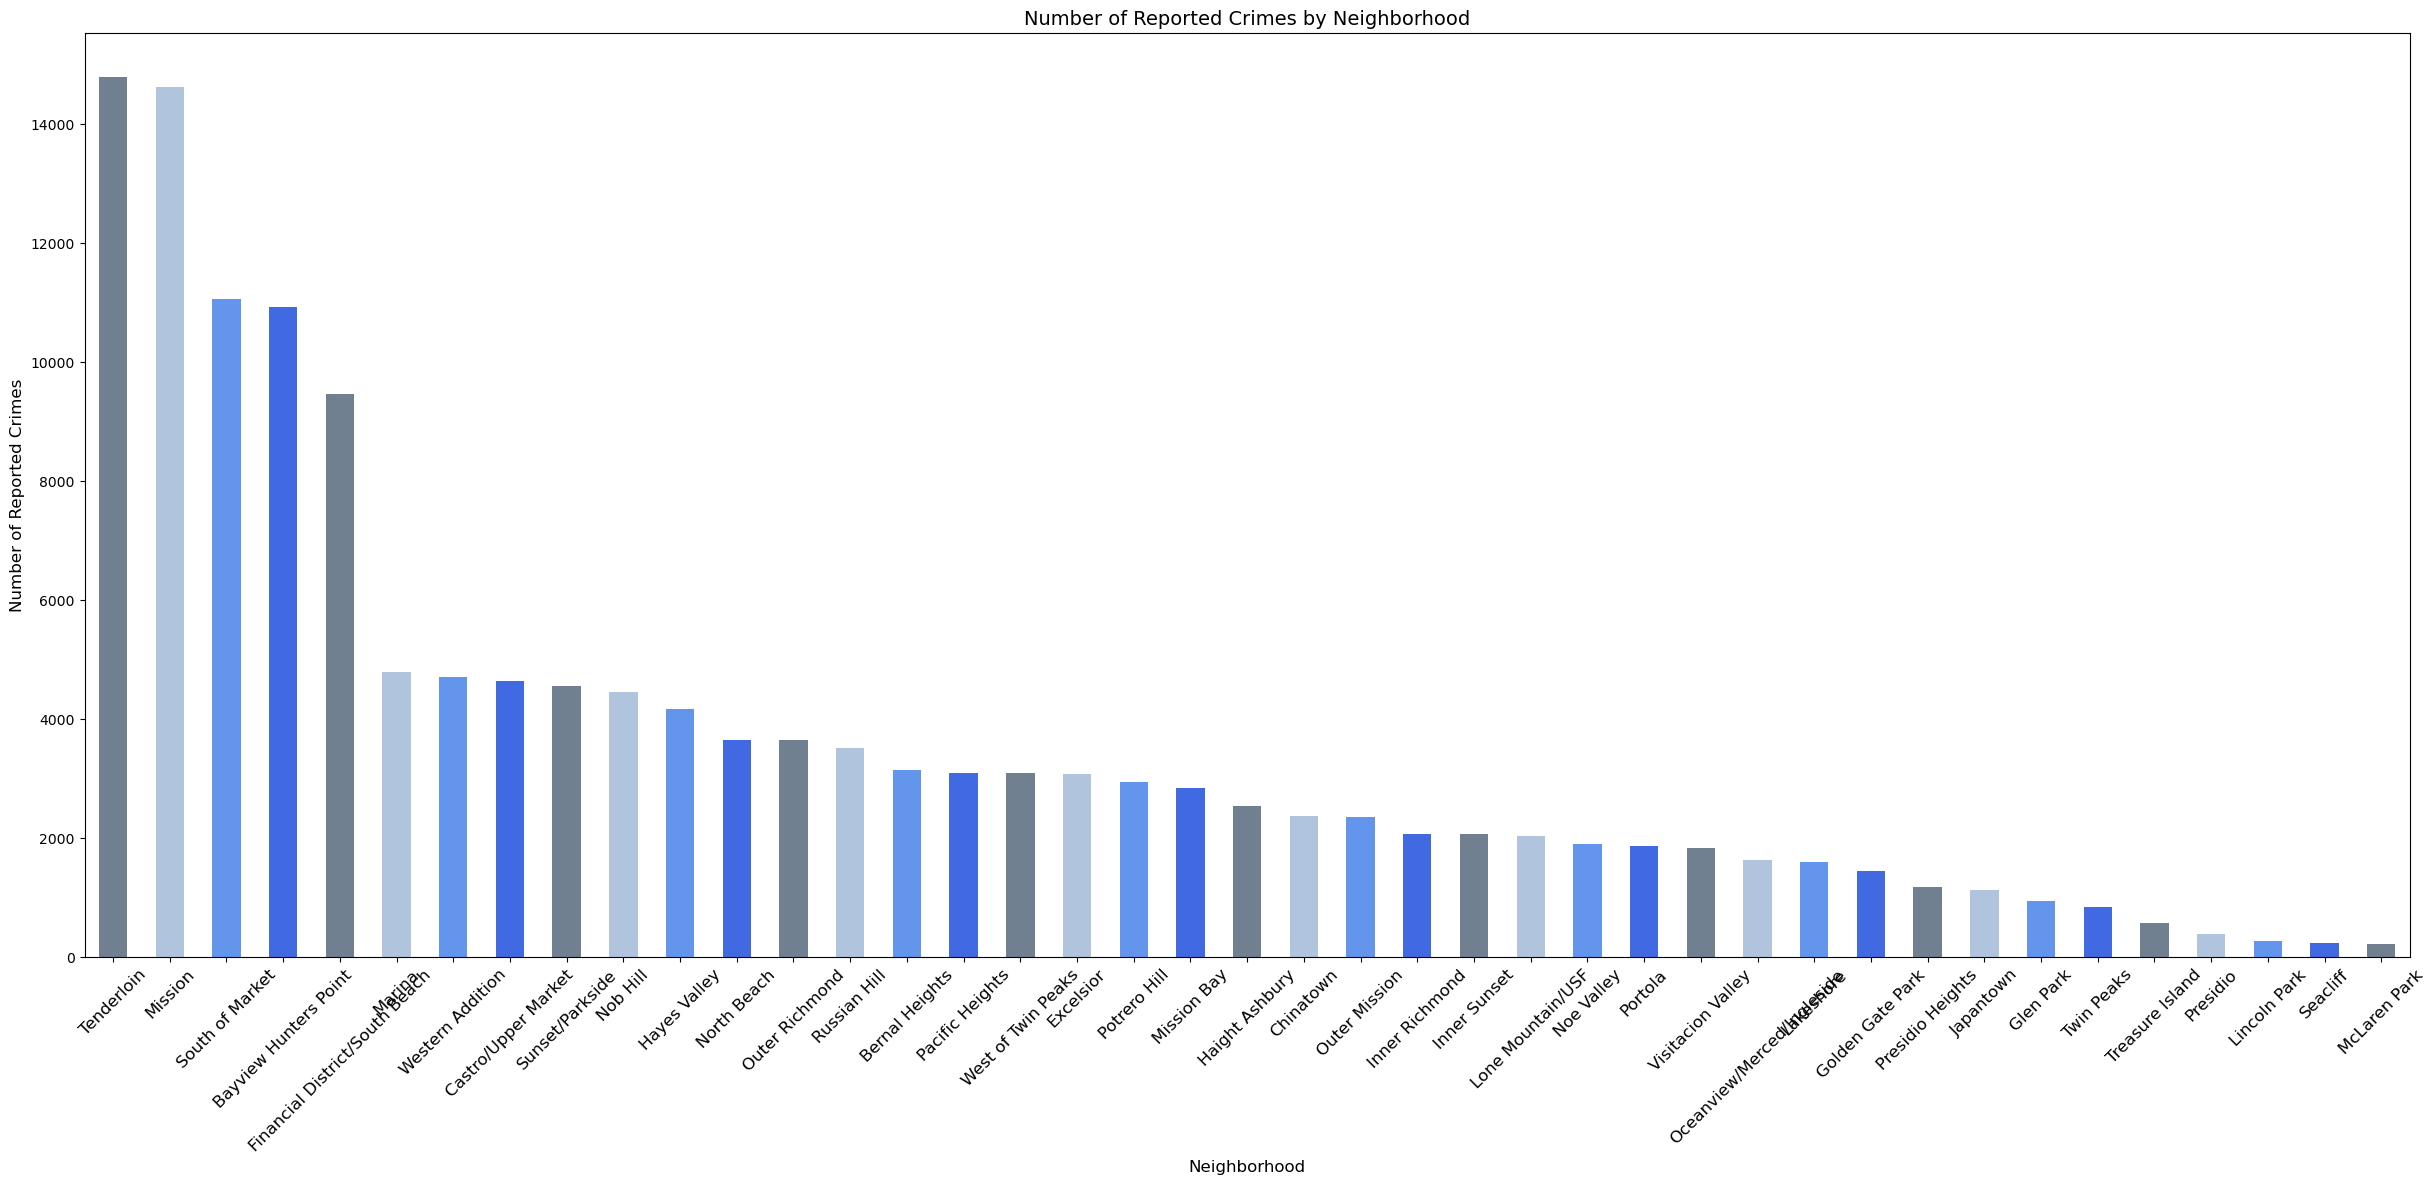

In [11]:
df_final.plot.bar(x = 'Neighborhood', y = 'Incidents', title = "Crime Incidents by Neighborhood", legend = None, rot= 45, figsize = (30, 12), color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue'])
plt.ylabel('Number of Reported Crimes', fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Neighborhood', fontsize = 12)
plt.title('Number of Reported Crimes by Neighborhood', fontsize = 14)
plt.show()

### 3.2. Folium Mapping

**Using geopy library to get the latitude and longitude values of San Francisco**

In [12]:
address = "San Francisco, CA"

geolocator = Nominatim(user_agent="san_francisco_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco city are 37.7790262, -122.419906.


Folium mapping will help visualize the location of each neighbourhood around San Francisco.  
**Creating a map of San Francisco with neighborhoods superimposed on top**  

In [13]:
# create map of San Francisco using latitude and longitude values
map_sf = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
map_sf 

### 3.3. Foursquare Analysis

**Defining a function to search for the most popular venues within a 0.5 mile radius of our neighborhoods.**

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Searching for the most popular venues within a 0.5 mile radius of our neighborhoods**  
note: The limit of number of venues returned by Foursquare API is 100.

In [15]:
SF_venues = getNearbyVenues(names=df_final['Neighborhood'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude'])
SF_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tenderloin,37.781879,-122.416309,Asian Art Museum,37.780178,-122.416505,Art Museum
1,Tenderloin,37.781879,-122.416309,Saigon Sandwich,37.783084,-122.417650,Sandwich Place
2,Tenderloin,37.781879,-122.416309,Philz Coffee,37.781266,-122.416901,Coffee Shop
3,Tenderloin,37.781879,-122.416309,Ales Unlimited: Beer Basement,37.782751,-122.415656,Beer Bar
4,Tenderloin,37.781879,-122.416309,Brenda's French Soul Food,37.782896,-122.418897,Southern / Soul Food Restaurant


In [16]:
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 281 uniques categories.


**Checking how many venues were returned for each neighborhood**

In [17]:
SF_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview Hunters Point,5,5,5,5,5,5
Bernal Heights,42,42,42,42,42,42
Castro/Upper Market,94,94,94,94,94,94
Chinatown,100,100,100,100,100,100
Excelsior,7,7,7,7,7,7
Financial District/South Beach,58,58,58,58,58,58
Glen Park,16,16,16,16,16,16
Golden Gate Park,7,7,7,7,7,7
Haight Ashbury,33,33,33,33,33,33


**Further analysis with one hot encoding**  
One hot encoding allows the representation of categorical data to be more expressive. Many machine learning algorithms cannot work with categorical data directly so the categories must be converted into numbers.

In [18]:
# one hot encoding
SF_venues_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SF_venues_onehot['Neighborhood'] = SF_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SF_venues_onehot.columns[-1]] + list(SF_venues_onehot.columns[:-1])
SF_venues_onehot = SF_venues_onehot[fixed_columns]

SF_venues_onehot.head()

,Zoo Exhibit,Accessories Store,Adult Boutique,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [19]:
SF_venues_grouped = SF_venues_onehot.groupby('Neighborhood').mean().reset_index()
SF_venues_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,Bayview Hunters Point,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
1,Bernal Heights,0.0,0.0,0.000000,0.023810,0.0,0.0,0.00,0.000000,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.023810
2,Castro/Upper Market,0.0,0.0,0.010638,0.010638,0.0,0.0,0.00,0.010638,0.0,...,0.0,0.0,0.00,0.021277,0.010638,0.0,0.0,0.0,0.0,0.021277
3,Chinatown,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01,0.000000,0.0,...,0.0,0.0,0.02,0.020000,0.000000,0.0,0.0,0.0,0.0,0.010000
4,Excelsior,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


**Identifying the top 5 venues of each neighborhood and the frequency of each venue category**

In [20]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in SF_venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SF_venues_grouped[SF_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayview Hunters Point----
               venue  freq
0      Jewelry Store   0.2
1               Park   0.2
2    Motorcycle Shop   0.2
3     Lighting Store   0.2
4  Food & Drink Shop   0.2


----Bernal Heights----
                venue  freq
0              Bakery  0.07
1         Coffee Shop  0.07
2                Park  0.07
3          Playground  0.07
4  Mexican Restaurant  0.05


----Castro/Upper Market----
             venue  freq
0          Gay Bar  0.09
1  Thai Restaurant  0.04
2      Coffee Shop  0.04
3             Park  0.04
4    Deli / Bodega  0.03


----Chinatown----
                venue  freq
0  Italian Restaurant  0.07
1  Chinese Restaurant  0.07
2         Pizza Place  0.06
3              Bakery  0.06
4                Café  0.05


----Excelsior----
              venue  freq
0    Baseball Field  0.43
1  Basketball Court  0.14
2     Bowling Green  0.14
3            Bakery  0.14
4        Playground  0.14


----Financial District/South Beach----
                 venue  freq
0

**Putting Foursquare data into a dataframe and identifying the most common venues in each neighborhood**

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SF_venues_grouped['Neighborhood']

for ind in np.arange(SF_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview Hunters Point,Jewelry Store,Park,Motorcycle Shop,Lighting Store,Food & Drink Shop,Zoo Exhibit,Other Nightlife,Pedestrian Plaza,Parking,Paper / Office Supplies Store
1,Bernal Heights,Bakery,Coffee Shop,Park,Playground,Mexican Restaurant,Italian Restaurant,Gourmet Shop,Brewery,Food Truck,Indian Restaurant
2,Castro/Upper Market,Gay Bar,Thai Restaurant,Coffee Shop,Park,Deli / Bodega,Yoga Studio,Wine Bar,Scenic Lookout,Seafood Restaurant,Indian Restaurant
3,Chinatown,Italian Restaurant,Chinese Restaurant,Pizza Place,Bakery,Café,Coffee Shop,Men's Store,New American Restaurant,Cocktail Bar,Seafood Restaurant
4,Excelsior,Baseball Field,Basketball Court,Bowling Green,Bakery,Playground,Paper / Office Supplies Store,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Parking


### 3.4. Neighborhood Cluster Analysis

Run k-means to cluster the neighborhood into 5 clusters

In [22]:
# set number of clusters
kclusters = 5

SF_grouped_clustering = SF_venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 4, 4, 4, 1, 4, 0, 2, 4, 4], dtype=int32)

**Creating a new dataframe that includes the cluster as well as the top 10 venue category for each neighborhood**

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_merged = df_final
df_merged = df_final.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Incidents,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Tenderloin,37.781879,-122.416309,14797,4,Vietnamese Restaurant,Coffee Shop,Sandwich Place,Café,Theater,Thai Restaurant,Mexican Restaurant,Performing Arts Venue,Hotel,Vegetarian / Vegan Restaurant
18,Mission,37.759713,-122.415678,14628,4,Café,Mexican Restaurant,New American Restaurant,Cocktail Bar,Coffee Shop,Art Gallery,Bar,Latin American Restaurant,Music Venue,Bubble Tea Shop
33,South of Market,37.777446,-122.406621,11056,4,Vietnamese Restaurant,Coffee Shop,Art Gallery,Nightclub,Sports Bar,Sandwich Place,Bar,Bakery,Clothing Store,Brewery
0,Bayview Hunters Point,37.725117,-122.379168,10926,3,Jewelry Store,Park,Motorcycle Shop,Lighting Store,Food & Drink Shop,Zoo Exhibit,Other Nightlife,Pedestrian Plaza,Parking,Paper / Office Supplies Store
5,Financial District/South Beach,37.795590,-122.392211,9454,4,Japanese Restaurant,Coffee Shop,Boat or Ferry,Food Truck,Ice Cream Shop,Scenic Lookout,Burger Joint,Candy Store,Seafood Restaurant,Thai Restaurant


**Visualizing the neighborhood clusters**

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_merged['Latitude'], 
        df_merged['Longitude'], 
        df_merged['Neighborhood'], 
        df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Analyzing the neighborhood clusters**

In [25]:
 df_merged.loc[df_merged['Cluster Labels'] == 0,df_merged.columns[[0] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Outer Richmond,Chinese Restaurant,Garden Center,American Restaurant,Park,Surf Spot,Café,Grocery Store,Trail,Motel,Liquor Store
39,West of Twin Peaks,Yoga Studio,Monument / Landmark,Park,Bus Line,Construction & Landscaping,Sushi Restaurant,Tree,Parking,Paper / Office Supplies Store,Outdoor Sculpture
11,Inner Sunset,Trail,Park,Sandwich Place,Sushi Restaurant,Bakery,Bookstore,Bus Stop,Grocery Store,Nail Salon,Indian Restaurant
23,Oceanview/Merced/Ingleside,Playground,Japanese Restaurant,Liquor Store,Bus Station,Other Nightlife,Pedestrian Plaza,Parking,Park,Paper / Office Supplies Store,Outdoor Sculpture
13,Lakeshore,Golf Course,American Restaurant,Lake,Park,Gym Pool,Picnic Area,Zoo Exhibit,Outdoor Sculpture,Pedestrian Plaza,Parking
6,Glen Park,Park,Playground,Trail,Grocery Store,Coffee Shop,Tennis Court,Shopping Mall,Dim Sum Restaurant,Pharmacy,Shipping Store
37,Twin Peaks,Scenic Lookout,Trail,Hill,Reservoir,Playground,Monument / Landmark,Zoo Exhibit,Other Nightlife,Parking,Park
14,Lincoln Park,Outdoor Sculpture,Monument / Landmark,Exhibit,Scenic Lookout,Sculpture Garden,Public Art,Beach,Bus Stop,Gift Shop,Art Museum
32,Seacliff,Beach,Tea Room,Playground,Zoo Exhibit,Other Nightlife,Parking,Park,Paper / Office Supplies Store,Outdoor Sculpture,Organic Grocery
17,McLaren Park,Park,Pool,Trail,Playground,Dog Run,Outdoor Sculpture,Zoo Exhibit,Other Nightlife,Parking,Paper / Office Supplies Store


In [26]:
 df_merged.loc[df_merged['Cluster Labels'] == 1,df_merged.columns[[0] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Excelsior,Baseball Field,Basketball Court,Bowling Green,Bakery,Playground,Paper / Office Supplies Store,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Parking


In [27]:
 df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[0] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Golden Gate Park,Park,Thrift / Vintage Store,Intersection,Disc Golf,Other Nightlife,Performing Arts Venue,Pedestrian Plaza,Parking,Paper / Office Supplies Store,Outdoor Sculpture


In [28]:
 df_merged.loc[df_merged['Cluster Labels'] == 3,df_merged.columns[[0] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview Hunters Point,Jewelry Store,Park,Motorcycle Shop,Lighting Store,Food & Drink Shop,Zoo Exhibit,Other Nightlife,Pedestrian Plaza,Parking,Paper / Office Supplies Store


In [29]:
 df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[0] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Tenderloin,Vietnamese Restaurant,Coffee Shop,Sandwich Place,Café,Theater,Thai Restaurant,Mexican Restaurant,Performing Arts Venue,Hotel,Vegetarian / Vegan Restaurant
18,Mission,Café,Mexican Restaurant,New American Restaurant,Cocktail Bar,Coffee Shop,Art Gallery,Bar,Latin American Restaurant,Music Venue,Bubble Tea Shop
33,South of Market,Vietnamese Restaurant,Coffee Shop,Art Gallery,Nightclub,Sports Bar,Sandwich Place,Bar,Bakery,Clothing Store,Brewery
5,Financial District/South Beach,Japanese Restaurant,Coffee Shop,Boat or Ferry,Food Truck,Ice Cream Shop,Scenic Lookout,Burger Joint,Candy Store,Seafood Restaurant,Thai Restaurant
16,Marina,Monument / Landmark,Gym,Gym / Fitness Center,Bank,Coffee Shop,Park,Lighthouse,Food Truck,Athletics & Sports,Pedestrian Plaza
40,Western Addition,Gift Shop,Japanese Restaurant,Shopping Mall,Ramen Restaurant,Tea Room,New American Restaurant,Creperie,Hotel,Sushi Restaurant,Ice Cream Shop
2,Castro/Upper Market,Gay Bar,Thai Restaurant,Coffee Shop,Park,Deli / Bodega,Yoga Studio,Wine Bar,Scenic Lookout,Seafood Restaurant,Indian Restaurant
34,Sunset/Parkside,Trail,Korean Restaurant,Bakery,Pizza Place,Coffee Shop,Pet Store,Food Truck,Chinese Restaurant,Café,Bus Station
20,Nob Hill,Hotel,Coffee Shop,Bar,Grocery Store,Italian Restaurant,Café,Spa,Breakfast Spot,American Restaurant,French Restaurant
9,Hayes Valley,Wine Bar,Sushi Restaurant,French Restaurant,Cocktail Bar,Boutique,Pizza Place,Clothing Store,Dessert Shop,Coffee Shop,Ice Cream Shop


## 4. Reults and Discussion

We were able to access San Francisco crime data and with this information we were able to identify the top neighborhoods with the highest crime numbers and the neighborhoods with the lowest crime numbers. However, it is important to note when comparing crime rates across neighborhoods that not all neighborhoods are equal in size and population. While neighborhood X has more crime frequency than neighborhood Y, it does not mean neighborhood X has a higher crime rate than neighborhood Y. This is to be considered in the analysis. Our analysis has informed us that: 
- Beaches, Parks, and Trails are the most common venue category in neighborhoods with the least amount of crime. 
- Restaurants, Cafes, Nightclubs, and Bars are the most common venue category in neighborhoods with the most amount of crime.
- Chinatown, Hayes Valley, Nob Hill, Tenderloin, and Japantown are neighborhoods with the most venues.

Based on the analysis, I would take my partner to Golden Gate Park due to its top 2 venue category being parks and thrift stores which they highly enjoy. Japantown also seems to be a very suitable option due to its high venue count with low crime frequency. 


## 5. Conclusion

This study aimed to explore, segement, and cluster the neighborhoods of San Francisco.The analysis was conducted using python libraries to process data, Foursquare API to retrive venues in San Francisco neighborhoods, and Folium to visualize, cluster, and segment neighborhoods.